# Creating records 
## Pipeline 2.0
##### ASTROMER dev team

*Feb 27 2024*

In [2]:
cd /home

/home


In [3]:
import matplotlib.pyplot as plt
import polars as pl
import pandas as pd
import numpy as np
import os

from src.data.record import DataPipeline, create_config_toml

%load_ext autoreload
%autoreload 2

## Describing raw data before record creation

In [3]:
metadata = pl.read_parquet('./data/praw/ogle/metadata.parquet')
single_md = metadata.filter(pl.col('shard') == 0)
observations = pl.read_parquet('./data/praw/ogle/light_curves/shard_000.parquet')

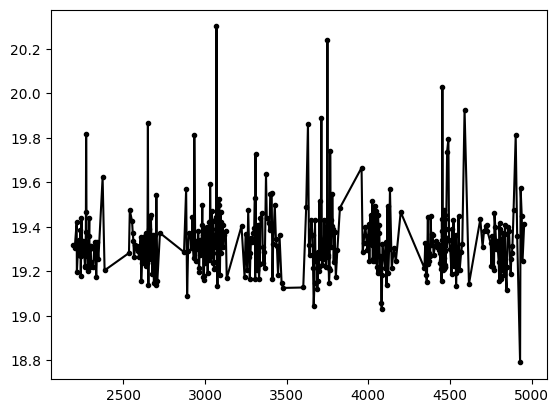

In [4]:
fig, axes = plt.subplots(1, 1)
curve = observations.filter(pl.col('newID') == 1)
axes.plot(curve['mjd'], curve['mag'], marker='.', color='k')
plt.show()

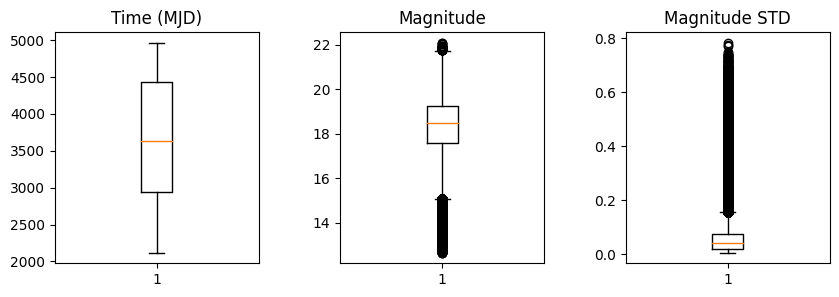

In [5]:
fig, axes = plt.subplots(1, 3, figsize=(10, 3), gridspec_kw={'wspace':0.4}, dpi=100)
axes[0].boxplot(observations['mjd'])
axes[0].set_title('Time (MJD)')
axes[1].boxplot(observations['mag'])
axes[1].set_title('Magnitude')
axes[2].boxplot(observations['errmag'])
axes[2].set_title('Magnitude STD')
plt.show()

In [82]:
def lightcurve_step(inputs):
    p99 = inputs.quantile(0.95, 'nearest')
    p01 = inputs.quantile(0.05, 'nearest')
    inputs = inputs.filter(pl.col('mag') < p99['mag'])
    inputs = inputs.filter(pl.col('mag') > p01['mag'])
    return inputs
    
observations_f = observations.filter((pl.col('errmag') > 0)\
                                     & (pl.col('errmag') < 1.) \
                                     & (pl.col('errmag') < pl.col('mag').abs()))

observations_f = observations_f.group_by('newID').apply(lightcurve_step)

observations_f.shape[0]/observations.shape[0]

/tmp/ipykernel_2705669/839042409.py:12: DeprecationWarning: `apply` is deprecated. It has been renamed to `map_groups`.
  observations_f = observations_f.group_by('newID').apply(lightcurve_step)


0.8937597738688192

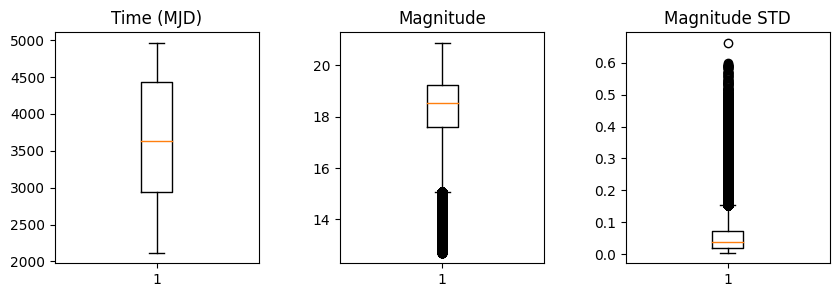

In [83]:
fig, axes = plt.subplots(1, 3, figsize=(10, 3), gridspec_kw={'wspace':0.4}, dpi=100)
axes[0].boxplot(observations_f['mjd'])
axes[0].set_title('Time (MJD)')
axes[1].boxplot(observations_f['mag'])
axes[1].set_title('Magnitude')
axes[2].boxplot(observations_f['errmag'])
axes[2].set_title('Magnitude STD')
plt.show()

## Creating records

In order to specify record features you have to create a `config.toml` file. A template of the config file is as following: 

```
[id_column]
    value = 'newID'
    dtype = 'integer'  
    
[target]
    value = './data/records_parquet/alcock'
    dtype = 'string' 

[context_features]
	value = ['ID', 'Label', 'Class', 'Band']
	dtypes = ['string', 'integer', 'string', 'integer']

[sequential_features]
	value = ['mjd', 'mag', 'err']
	dtypes = ['float', 'float', 'float']
```

where `newID` is an integer-based id used for efficently filter light curves. `general.target` specifies the target directory where tf.records will be stored. `context_features` are the columns from the `metadata.csv` containing static information of the light curve while `sequential_features` are the time-depended features. The name of the columns both for context and sequential features should match the names of the column in their corresponding tables (`metadata.csv` and `lightcurves/shard_xxx.parquet`).

In [20]:
METAPATH = './data/praw/atlas/metadata.parquet'
OBSPATH  = './data/praw/atlas/light_curves/'

In [18]:
metadata = pd.read_parquet(METAPATH)

In [24]:
metadata.columns, pl.read_parquet(os.path.join(OBSPATH, 'shard_000.parquet')).columns
metadata['N']#.astype(str)

0          157
1          154
2          178
3           69
4           72
          ... 
4719916     54
4719917     77
4719918     73
4719919     92
4719920    105
Name: N, Length: 4719921, dtype: int64

use `create_config_toml` to easily create a config file

In [113]:
create_config_toml(parquet_id='newID',
                   target='./data/precords/ogle/',
                   context_features=['ID', 'Label', 'Class', 'N', 'Band', 'shard'],
                   sequential_features=['mjd', 'mag', 'errmag'],
                   context_dtypes=['string', 'integer', 'string', 'integer', 'integer', 'integer'],
                   sequential_dtypes=['float', 'float', 'float'])

[INFO] Toml file succefully created at: ./data/precords/ogle/


In [114]:
metadata.sample()

,ID,Class,Path,N,Band,sset,newID,path,Label,shard
66775,OGLE-LMC-LPV-32151,OSARG,OGLE-LMC-LPV-32151.dat,490,1.0,train,66775,data/raw_data/ogle/LCs/OGLE-LMC-LPV-32151.dat,4,3


### Using DataPipeline class

We first define our train-test-validation subsets using the `ID`

In [102]:
test_metadata = metadata.sample(frac=0.25)
rest = metadata[~metadata['newID'].isin(test_metadata['newID'])]
assert test_metadata['newID'].isin(rest['newID']).sum() == 0 # check if there are duplicated indices

validation_metadata = rest.sample(frac=0.25)
train_metadata = rest[~rest['newID'].isin(validation_metadata['newID'])]
assert train_metadata['newID'].isin(validation_metadata['newID']).sum() == 0 # check if there are duplicated indices

it is important to define a new column in metadata with the `subset_k` tag, where `k` is the number of the fold. You can create as many folds as you want while creating more `subset` columns.

In [103]:
train_metadata['subset_0'] = ['train']*train_metadata.shape[0]
validation_metadata['subset_0'] = ['validation']*validation_metadata.shape[0]
test_metadata['subset_0'] = ['test']*test_metadata.shape[0]

/tmp/ipykernel_2705669/2469551710.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_metadata['subset_0'] = ['train']*train_metadata.shape[0]


After having all defined we create our final metadata:

In [104]:
final_metadata = pd.concat([train_metadata, validation_metadata, test_metadata])
final_metadata['subset_0'].unique()

array(['train', 'validation', 'test'], dtype=object)

once everything is ready in our metadata csv we can start using the `DataPipeline` class

In [105]:
# Create an instance of DataPipeline
config_path = './data/praw/ogle/config.toml'

pipeline = DataPipeline(metadata=final_metadata,
                        config_path=config_path)

[INFO] 393103 samples loaded


In [106]:
pipeline.metadata.sample(4)

,ID,Class,Path,N,Band,sset,newID,path,Label,shard,subset_0
322202,OGLE-BLG-LPV-048304,OSARG,OGLE-BLG-LPV-048304.dat,639,1.0,train,322202,data/raw_data/ogle/LCs/OGLE-BLG-LPV-048304.dat,4,16,train
87706,OGLE-LMC-LPV-01109,SRV,OGLE-LMC-LPV-01109.dat,310,1.0,train,87706,data/raw_data/ogle/LCs/OGLE-LMC-LPV-01109.dat,7,4,test
291915,OGLE-BLG-LPV-065053,OSARG,OGLE-BLG-LPV-065053.dat,1368,1.0,train,291915,data/raw_data/ogle/LCs/OGLE-BLG-LPV-065053.dat,4,14,train
372872,OGLE-BLG-LPV-187033,OSARG,OGLE-BLG-LPV-187033.dat,326,1.0,train,372872,data/raw_data/ogle/LCs/OGLE-BLG-LPV-187033.dat,4,18,test


In [107]:
for k in range(1):
    train_subset = pipeline.metadata[pipeline.metadata[f'subset_{k}'] == 'train']
    val_subset   = pipeline.metadata[pipeline.metadata[f'subset_{k}'] == 'validation']
    test_subset  = pipeline.metadata[pipeline.metadata[f'subset_{k}'] == 'test']

    print(train_subset.shape, val_subset.shape, test_subset.shape)

    print('test in train?: ', test_subset['ID'].isin(train_subset['ID']).all(),'\n',
          'val in train?: ', val_subset['ID'].isin(train_subset['ID']).all(),'\n',
          'val in test?: ', val_subset['ID'].isin(test_subset['ID']).all())

(221120, 11) (73707, 11) (98276, 11)
test in train?:  False 
 val in train?:  False 
 val in test?:  False


Now it is **time to the pipeline**

In [108]:
pipeline.context_features, pipeline.context_features_dtype

(['ID', 'Label', 'Class', 'N', 'Band', 'shard'],
 ['string', 'integer', 'string', 'integer', 'integer', 'integer'])

In [109]:
%%time
var = pipeline.run(observations_path=OBSPATH, 
                   n_jobs=8,
                   elements_per_shard=20000)

2024-05-31 20:52:43,479 - INFO - Starting DataPipeline operations


[INFO] Reading parquet
[INFO] Light curves loaded


Processing fold 1/1 - train:   0%|                                                                                                                                     | 0/3 [00:00<?, ?it/s]2024-05-31 20:53:52.979450: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-31 20:53:52.979788: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-31 20:53:52.980068: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-31 20:53:52.980345: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful 

Processing fold 1/1 - test: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [04:21<00:00, 87.10s/it]
2024-05-31 20:58:13,468 - INFO - Finished execution of DataPipeline operations


CPU times: user 36min 45s, sys: 4min 12s, total: 40min 57s
Wall time: 5min 30s


### Customize what happens within the preprocess function

You must keep the same parameters of the method i.e., `row, context_features, sequential_features`. 

Also the **output** should be tuple containing the lightcurve (`pd.DataFrame`) and the context values (`dict`)


To modify the `process_sample` method we need to create a new class (`MyPipeline`) that inherits from `DataPipeline` 

In [115]:
import polars as pl
class MyPipeline(DataPipeline):
    def lightcurve_step(self, inputs):
        """
        Preprocessing applied to each light curve separately
        """
        # First feature is time
        inputs = inputs.sort(self.sequential_features[0], descending=True) 
        p99 = inputs.quantile(0.95, 'nearest')
        p01 = inputs.quantile(0.05, 'nearest')
        inputs = inputs.filter(pl.col('mag') < p99['mag'])
        inputs = inputs.filter(pl.col('mag') > p01['mag'])
        return inputs

    def observations_step(self):
        """
        Preprocessing applied to all observations. Filter only
        """
        fn_0 = pl.col('errmag') > 0
        fn_1 = pl.col('errmag') < 1.
        fn_2 = pl.col('errmag') < pl.col('mag').abs()
        return fn_0 & fn_1 & fn_2

Next steps are the same as using the original `DataPipeline` class

In [116]:
custom_pipeline = MyPipeline(metadata=final_metadata,
                             config_path=config_path)

[INFO] 393103 samples loaded


In [117]:
%%time
var = custom_pipeline.run(observations_path=OBSPATH, 
                           n_jobs=8,
                           elements_per_shard=2000)

2024-05-31 21:02:32,283 - INFO - Starting DataPipeline operations


[INFO] Reading parquet
[INFO] Light curves loaded


Processing fold 1/1 - test: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [03:55<00:00, 78.55s/it]
2024-05-31 21:10:21,772 - INFO - Finished execution of DataPipeline operations


CPU times: user 2h 10min 39s, sys: 10min 38s, total: 2h 21min 18s
Wall time: 7min 49s


# Reading

In [4]:
import tensorflow as tf
from src.data.loaders import get_loader
from src.data.zero import pretraining_pipeline
import glob
import os

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
root = './data/precords/maogat/fold_0/train/'
window_size = 200
probed_frac = .2
random_frac = 0.
same_frac = 0.

In [6]:
dataset = get_loader(root, 
                     window_size=window_size,
                     batch_size=2,
                     probed_frac=probed_frac,
                     random_frac=random_frac,
                     same_frac=same_frac,
                     shuffle=True,
                     sampling=False,
                     aversion='base',
                     normalize='zero-mean',
                     cache=True)

[INFO] Probed: 0.20 Random: 0.00 Same: 0.00
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


2024-06-04 17:25:17.432080: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-04 17:25:17.432453: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-04 17:25:17.432778: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-04 17:25:17.433105: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-04 17:25:17.436522: I tensorflow/compiler/xla/stream_executo

[INFO] Repeating dataset x1 times
[INFO] Normalization:  zero-mean
[INFO] Loading PT task: Masking
[INFO] Cache activated


2024-06-04 17:31:50.533385: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


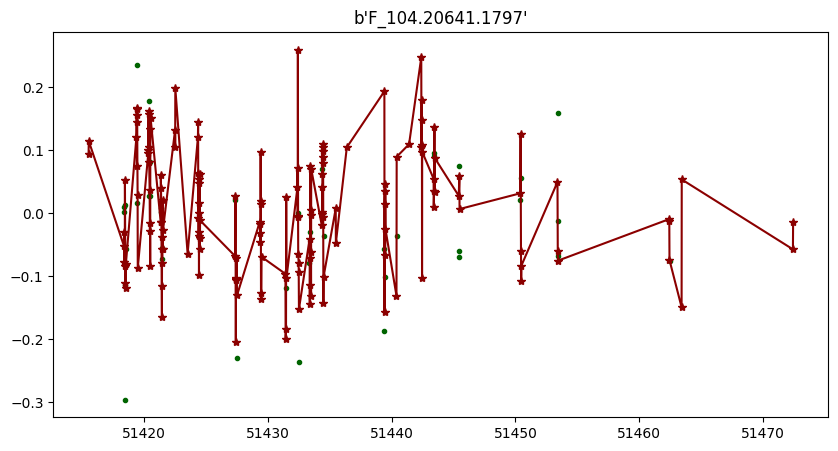

In [10]:
plt.figure(figsize=(10, 5))
for x, y in dataset.take(1):
    plt.title(y['lcid'][0].numpy())
    xinp = tf.boolean_mask(x['input'][0], 1.-x['mask_in'][0])
    tinp = tf.boolean_mask(x['times'][0], 1.-x['mask_in'][0])
    
    xinp_2 = tf.boolean_mask(x['input'][0], y['mask_out'][0])
    tinp_2 = tf.boolean_mask(x['times'][0], y['mask_out'][0])
    plt.plot(tinp_2, xinp_2, marker='.', linestyle='', color='darkgreen')
    plt.plot(tinp, xinp, marker='*', linestyle='-', color='darkred')
    
    

In [16]:
zero_loader = pretraining_pipeline(root,
                                    batch_size= 16, 
                                    window_size=window_size,
                                    shuffle=False,
                                    sampling=False,
                                    repeat=1,
                                    msk_frac=probed_frac,
                                    rnd_frac=random_frac,
                                    same_frac=random_frac)

[INFO] Repeating dataset x1 times
[INFO] Loading PT task: Masking


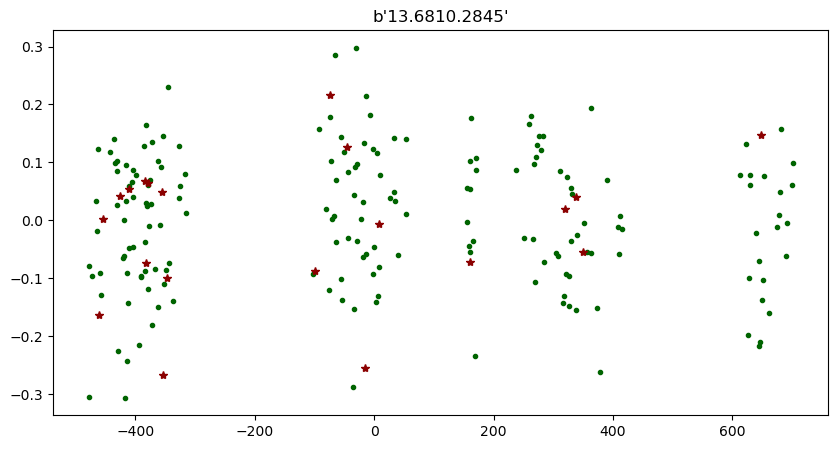

In [14]:
plt.figure(figsize=(10, 5))
for x, y in zero_loader.take(1):
    plt.title(y['lcid'][0].numpy())
    xinp = tf.boolean_mask(x['input'][0], 1.-x['mask_in'][0])
    tinp = tf.boolean_mask(x['times'][0], 1.-x['mask_in'][0])
    
    xinp_2 = tf.boolean_mask(x['input'][0], y['mask_out'][0])
    tinp_2 = tf.boolean_mask(x['times'][0], y['mask_out'][0])
    plt.plot(tinp_2, xinp_2, marker='.', linestyle='', color='darkgreen')
    plt.plot(tinp, xinp, marker='*', linestyle='', color='darkred')